In [26]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass

Observe que cuando la distancia entre 2 cuerpos es muy pequeña la fuerza tiende a infinito, ya que esta es de la forma

$$
\vec{F} = -\frac{GMm}{|\vec{r_2}-\vec{r_1}|^3}(\vec{ r_2 } - \vec{ r_1 })
$$

Para resolver esto implementaremos una tecnica llamada **_gravitational softening_** la cual consiste en calcular la fuerza como

$$
\vec{F} = -\frac{GMm}{(|\vec{r_2}-\vec{r_1}|^2 + \varepsilon^2)^{3/2}}(\vec{ r_2 } - \vec{ r_1 })
$$

Referencias:

[Gravitational softening as a smoothing operation](https://arxiv.org/abs/1205.2729)


In [27]:
G = 6.67430e-11


def three_body_system_for_solve_ivp(t, state, m1, m2, m3, gravitational_softening=1e-2):
    """
    Calculate the time derivative for every member of the sate vector for the three-body problem
    for the solve_ivp method.

    state: 18 elements array with the following structure (Those are instantaneous
    values of the position and velocity of each of the three bodies),
       [x1, y1, z1, vx1, vy1, vz1,
        x2, y2, z2, vx2, vy2, vz2,
        x3, y3, z3, vx3, vy3, vz3]
    t: time (required by solve_ivp method)
    m1, m2, m3: masses of the three bodies
    gravitational_softening: a small value to avoid division by zero in the gravitational force calculation
    """
    x1, y1, z1, vx1, vy1, vz1, x2, y2, z2, vx2, vy2, vz2, x3, y3, z3, vx3, vy3, vz3 = (
        state
    )

    r1 = np.array([x1, y1, z1])
    r2 = np.array([x2, y2, z2])
    r3 = np.array([x3, y3, z3])

    r12 = r2 - r1
    r13 = r3 - r1
    r23 = r3 - r2

    d12 = np.sqrt(np.linalg.norm(r12) ** 2 + gravitational_softening**2)
    d13 = np.sqrt(np.linalg.norm(r13) ** 2 + gravitational_softening**2)
    d23 = np.sqrt(np.linalg.norm(r23) ** 2 + gravitational_softening**2)

    a1 = G * m2 * r12 / d12**3 + G * m3 * r13 / d13**3
    a2 = G * m1 * (-r12) / d12**3 + G * m3 * r23 / d23**3
    a3 = G * m1 * (-r13) / d13**3 + G * m2 * (-r23) / d23**3

    return [
        vx1,
        vy1,
        vz1,
        a1[0],
        a1[1],
        a1[2],
        vx2,
        vy2,
        vz2,
        a2[0],
        a2[1],
        a2[2],
        vx3,
        vy3,
        vz3,
        a3[0],
        a3[1],
        a3[2],
    ]


def three_body_system_for_leap_frog(
    state, m1, m2, m3, dt, gravitational_softening=1e-2
):
    x1, y1, z1, vx1, vy1, vz1, x2, y2, z2, vx2, vy2, vz2, x3, y3, z3, vx3, vy3, vz3 = (
        state
    )

    r1 = np.array([x1, y1, z1])
    r2 = np.array([x2, y2, z2])
    r3 = np.array([x3, y3, z3])

    r12 = r2 - r1
    r13 = r3 - r1
    r23 = r3 - r2

    d12 = np.sqrt(np.linalg.norm(r12) ** 2 + gravitational_softening**2)
    d13 = np.sqrt(np.linalg.norm(r13) ** 2 + gravitational_softening**2)
    d23 = np.sqrt(np.linalg.norm(r23) ** 2 + gravitational_softening**2)

    a1 = G * m2 * r12 / d12**3 + G * m3 * r13 / d13**3
    a2 = G * m1 * (-r12) / d12**3 + G * m3 * r23 / d23**3
    a3 = G * m1 * (-r13) / d13**3 + G * m2 * (-r23) / d23**3

    v1_half_dt = np.array([vx1, vy1, vz1]) + 0.5 * a1 * dt
    v2_half_dt = np.array([vx2, vy2, vz2]) + 0.5 * a2 * dt
    v3_half_dt = np.array([vx3, vy3, vz3]) + 0.5 * a3 * dt

    r1_dt = r1 + v1_half_dt * dt
    r2_dt = r2 + v2_half_dt * dt
    r3_dt = r3 + v3_half_dt * dt

    r12_new = r2_dt - r1_dt
    r13_new = r3_dt - r1_dt
    r23_new = r3_dt - r2_dt

    d12_new = np.sqrt(np.linalg.norm(r12_new) ** 2 + gravitational_softening**2)
    d13_new = np.sqrt(np.linalg.norm(r13_new) ** 2 + gravitational_softening**2)
    d23_new = np.sqrt(np.linalg.norm(r23_new) ** 2 + gravitational_softening**2)

    a1_new = G * m2 * r12_new / d12_new**3 + G * m3 * r13_new / d13_new**3
    a2_new = G * m1 * (-r12_new) / d12_new**3 + G * m3 * r23_new / d23_new**3
    a3_new = G * m1 * (-r13_new) / d13_new**3 + G * m2 * (-r23_new) / d23_new**3

    v1_dt = v1_half_dt + 0.5 * a1_new * dt
    v2_dt = v2_half_dt + 0.5 * a2_new * dt
    v3_dt = v3_half_dt + 0.5 * a3_new * dt

    return np.concatenate((r1_dt, v1_dt, r2_dt, v2_dt, r3_dt, v3_dt))


In [66]:
from pythreejs import *
from IPython.display import display


@dataclass
class ThreeBodySolution:
    """This dataClass represents the solution of the three-body problem"""

    x1: np.ndarray
    y1: np.ndarray
    z1: np.ndarray
    vx1: np.ndarray
    vy1: np.ndarray
    vz1: np.ndarray
    x2: np.ndarray
    y2: np.ndarray
    z2: np.ndarray
    vx2: np.ndarray
    vy2: np.ndarray
    vz2: np.ndarray
    x3: np.ndarray
    y3: np.ndarray
    z3: np.ndarray
    vx3: np.ndarray
    vy3: np.ndarray
    vz3: np.ndarray


def solve_three_body_problem_solve_ivp(
    m1, m2, m3, state0, t, gs=1e-2
) -> ThreeBodySolution:
    """
    Solve the three body problem for the given masses and initial conditions

    state0: 18 elements array with the following structure (Those are instantaneous
    values of the position and velocity of each of the three bodies),
       [x1, y1, z1, vx1, vy1, vz1,
        x2, y2, z2, vx2, vy2, vz2,
        x3, y3, z3, vx3, vy3, vz3]
    m1, m2, m3: masses of the three bodies
    t: time (required by solve_ivp method)
    """
    solution = solve_ivp(
        three_body_system_for_solve_ivp,
        (t[0], t[-1]),
        state0,
        args=(m1, m2, m3, gs),
        t_eval=t,
        method="DOP853",
        rtol=1e-9,
        atol=1e-12,
    )
    return ThreeBodySolution(
        x1=solution.y[0],
        y1=solution.y[1],
        z1=solution.y[2],
        vx1=solution.y[3],
        vy1=solution.y[4],
        vz1=solution.y[5],
        x2=solution.y[6],
        y2=solution.y[7],
        z2=solution.y[8],
        vx2=solution.y[9],
        vy2=solution.y[10],
        vz2=solution.y[11],
        x3=solution.y[12],
        y3=solution.y[13],
        z3=solution.y[14],
        vx3=solution.y[15],
        vy3=solution.y[16],
        vz3=solution.y[17],
    )


def solve_three_body_problem_leap_frog(m1, m2, m3, state0, dt, steps, gs=1e-2):

    trajectory = np.zeros((steps, len(state0)), dtype=np.float64)
    trajectory[0] = state0

    for i in range(1, steps):
        trajectory[i] = three_body_system_for_leap_frog(
            trajectory[i - 1], m1, m2, m3, dt, gs
        )

    return ThreeBodySolution(
        x1=trajectory[:, 0],
        y1=trajectory[:, 1],
        z1=trajectory[:, 2],
        vx1=trajectory[:, 3],
        vy1=trajectory[:, 4],
        vz1=trajectory[:, 5],
        x2=trajectory[:, 6],
        y2=trajectory[:, 7],
        z2=trajectory[:, 8],
        vx2=trajectory[:, 9],
        vy2=trajectory[:, 10],
        vz2=trajectory[:, 11],
        x3=trajectory[:, 12],
        y3=trajectory[:, 13],
        z3=trajectory[:, 14],
        vx3=trajectory[:, 15],
        vy3=trajectory[:, 16],
        vz3=trajectory[:, 17],
    )

def save_three_body_solution(solution: ThreeBodySolution, filename: str):
    """
    Save the solution of the three-body problem to a CSV file
    """
    df = pd.DataFrame(
        {
            "x1": solution.x1,
            "y1": solution.y1,
            "z1": solution.z1,
            "vx1": solution.vx1,
            "vy1": solution.vy1,
            "vz1": solution.vz1,
            "x2": solution.x2,
            "y2": solution.y2,
            "z2": solution.z2,
            "vx2": solution.vx2,
            "vy2": solution.vy2,
            "vz2": solution.vz2,
            "x3": solution.x3,
            "y3": solution.y3,
            "z3": solution.z3,
            "vx3": solution.vx3,
            "vy3": solution.vy3,
            "vz3": solution.vz3,
        }
    )
    df.to_csv(filename, index=False)

def plot_projection_three_body_solution(solution: ThreeBodySolution, title: str):
    """
    Plot the solution of the three-body problem on the XY plane
    """
    plt.figure(figsize=(10, 10))
    plt.plot(solution.x1, solution.y1, ".", markersize=1, label="Cuerpo 1")
    plt.plot(solution.x2, solution.y2, ".", markersize=1, label="Cuerpo 2")
    plt.plot(solution.x3, solution.y3, ".", markersize=1, label="Cuerpo 3")
    plt.title(title)
    plt.legend()
    plt.show()


def plot_three_body_solution(solution: ThreeBodySolution, title: str):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    x1, y1, z1 = solution.x1, solution.y1, solution.z1
    x2, y2, z2 = solution.x2, solution.y2, solution.z2
    x3, y3, z3 = solution.x3, solution.y3, solution.z3

    ax.plot(x1, y1, z1, ".", markersize=1, label="Cuerpo 1")
    ax.plot(x2, y2, z2, ".", markersize=1, label="Cuerpo 2")
    ax.plot(x3, y3, z3, ".", markersize=1, label="Cuerpo 3")

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)
    ax.legend()
    plt.show()


def calculate_mechanical_energy(solution: ThreeBodySolution, m1, m2, m3, num_points, t, plot=True):
    potential_energy = np.zeros(num_points)
    kinetic_energy = np.zeros(num_points)

    for i in range(num_points):
        r1 = np.array([solution.x1[i], solution.y1[i], solution.z1[i]])
        r2 = np.array([solution.x2[i], solution.y2[i], solution.z2[i]])
        r3 = np.array([solution.x3[i], solution.y3[i], solution.z3[i]])

        v1 = np.array([solution.vx1[i], solution.vy1[i], solution.vz1[i]])
        v2 = np.array([solution.vx2[i], solution.vy2[i], solution.vz2[i]])
        v3 = np.array([solution.vx3[i], solution.vy3[i], solution.vz3[i]])

        potential_energy[i] = -G * (
            m1 * m2 / np.linalg.norm(r2 - r1)
            + m1 * m3 / np.linalg.norm(r3 - r1)
            + m2 * m3 / np.linalg.norm(r3 - r2)
        )
        kinetic_energy[i] = 0.5 * (
            m1 * np.linalg.norm(v1) ** 2
            + m2 * np.linalg.norm(v2) ** 2
            + m3 * np.linalg.norm(v3) ** 2
        )

    total_energy = potential_energy + kinetic_energy
    if not plot:
        return total_energy, potential_energy, kinetic_energy
    plt.figure(figsize=(10, 6))
    plt.plot(t, total_energy, color="green", label="Energía mecanica numerica")
    plt.axhline(
        y=np.mean(potential_energy + kinetic_energy),
        color="r",
        linestyle="--",
        label="E promedio",
    )
    plt.axhline(y=total_energy[0], color="b", linestyle="--", label="E inicial")
    plt.legend()
    plt.grid(True)
    plt.ylabel("Energía $[J]$")
    plt.xlabel("Tiempo $[S]$")
    plt.title("Energía Mecánica del sistema")
    plt.show()

    relative_error = np.abs(total_energy - total_energy[0]) 
    plt.figure(figsize=(10, 6))
    plt.plot(t, relative_error, label="Error Relativo de Energía", color="r")
    plt.yscale("log")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Error Relativo $\\frac{|E - E_0|}{|E_0|}$")
    plt.title("Evolución del Error Relativo en la Energía Mecánica")
    plt.legend()
    plt.grid(True)
    plt.show()

    return total_energy, potential_energy, kinetic_energy

# Runge-Kutta based solution

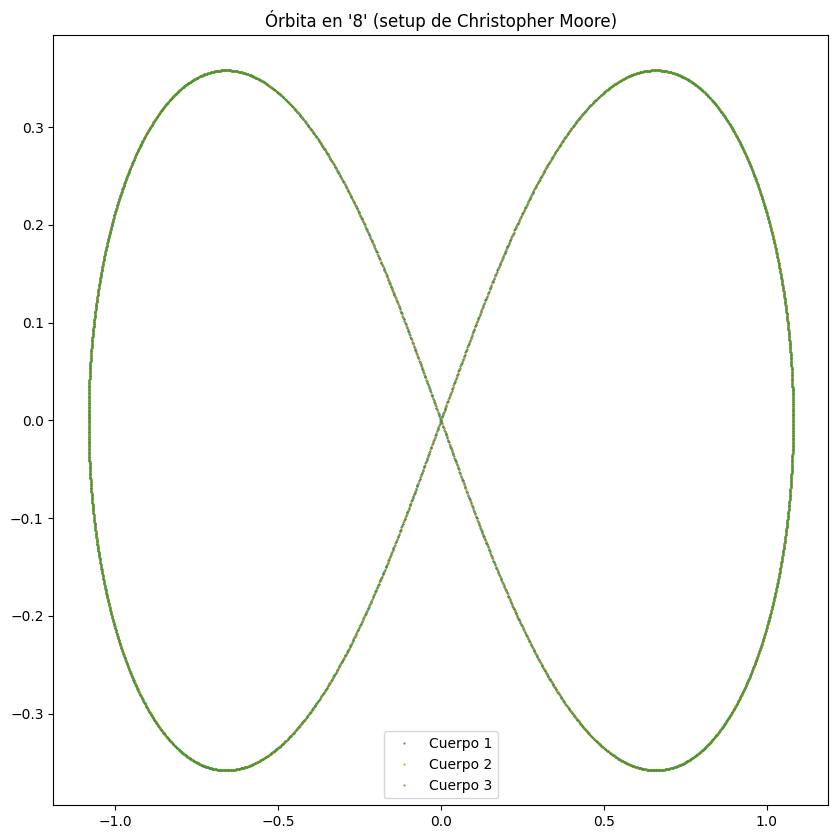

In [73]:
# ----------------------
# System parameters
# ----------------------

G = 1.0  # Gravitational constant normalized
m1 = m2 = m3 = 1.0

# ----------------------------
# Initial conditions
# ----------------------------

r1 = np.array([0.97000436, -0.24308753, 0.0])
r2 = np.array([-0.97000436, 0.24308753, 0.0])
r3 = np.array([0.0, 0.0, 0.0])

v1 = np.array([0.4662036850, 0.43236573, 0.0])
v2 = np.array([0.4662036850, 0.43236573, 0.0])
v3 = np.array([-0.93240737, -0.86473146, 0.0])

state0 = np.concatenate((r1, v1, r2, v2, r3, v3))
t_max = 200
num_points = 2000
t = np.linspace(0, t_max, num_points)

# ----------------------------
# Solve the system
# ----------------------------
sol = solve_three_body_problem_solve_ivp(m1, m2, m3, state0, t, 0)
save_three_body_solution
plot_projection_three_body_solution(sol, "Órbita en '8' (setup de Christopher Moore)")

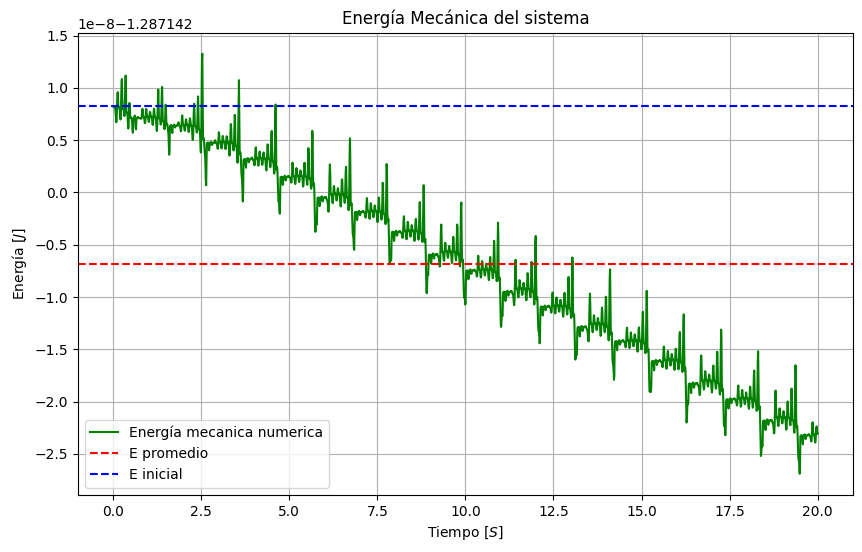

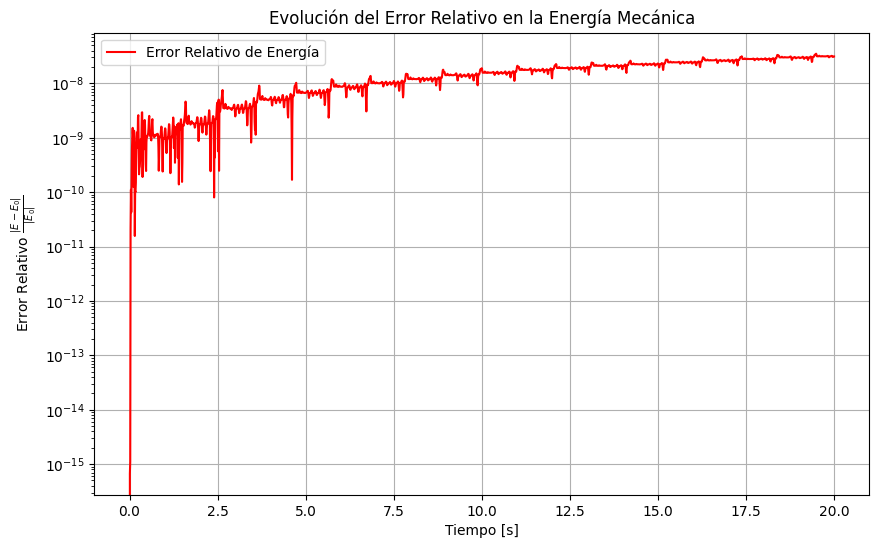

In [30]:
calculate_mechanical_energy(sol, m1, m2, m3, num_points, t)

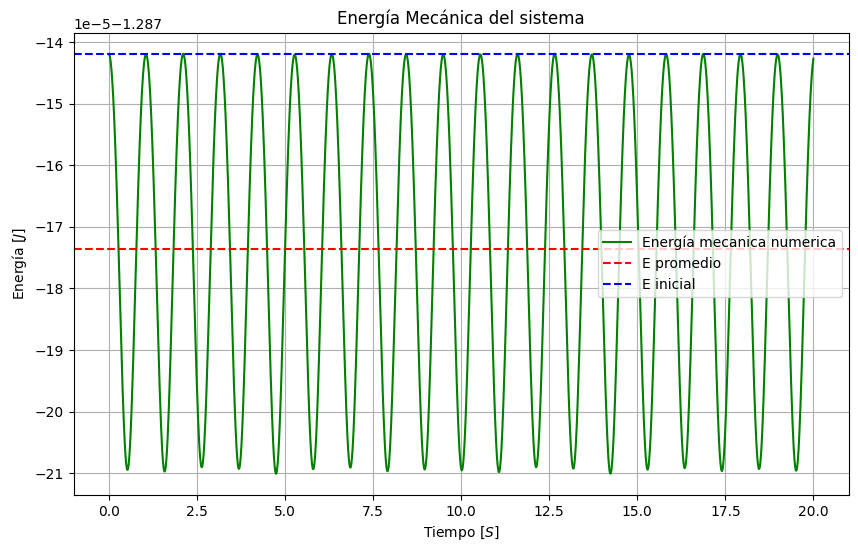

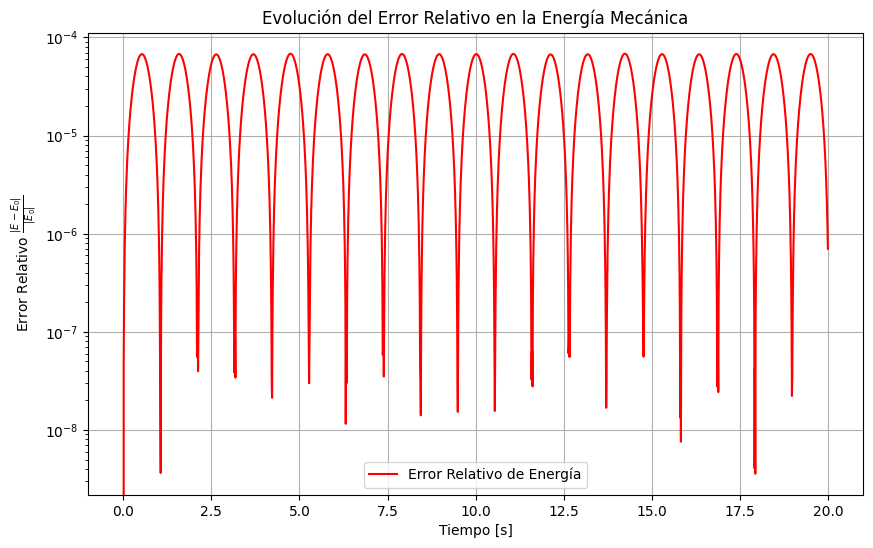

In [31]:
sol = solve_three_body_problem_solve_ivp(m1, m2, m3, state0, t, 1e-2)
calculate_mechanical_energy(sol, m1, m2, m3, num_points, t)

[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]


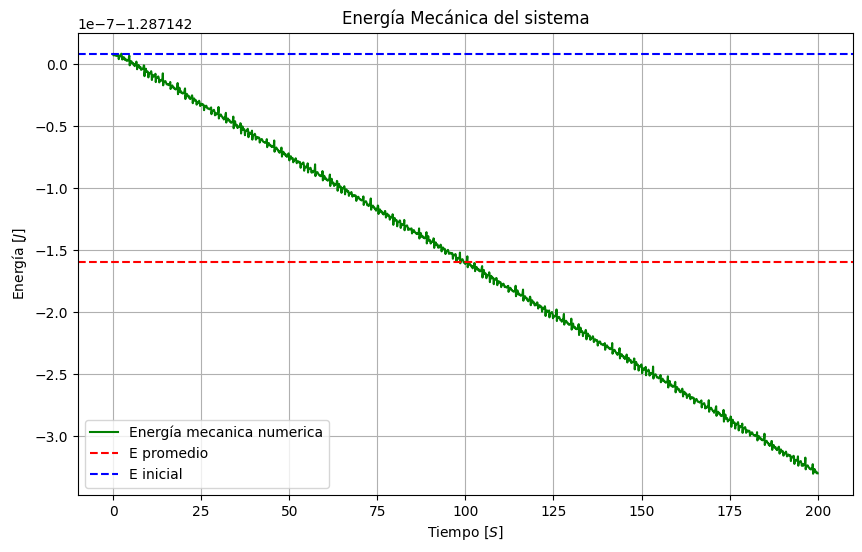

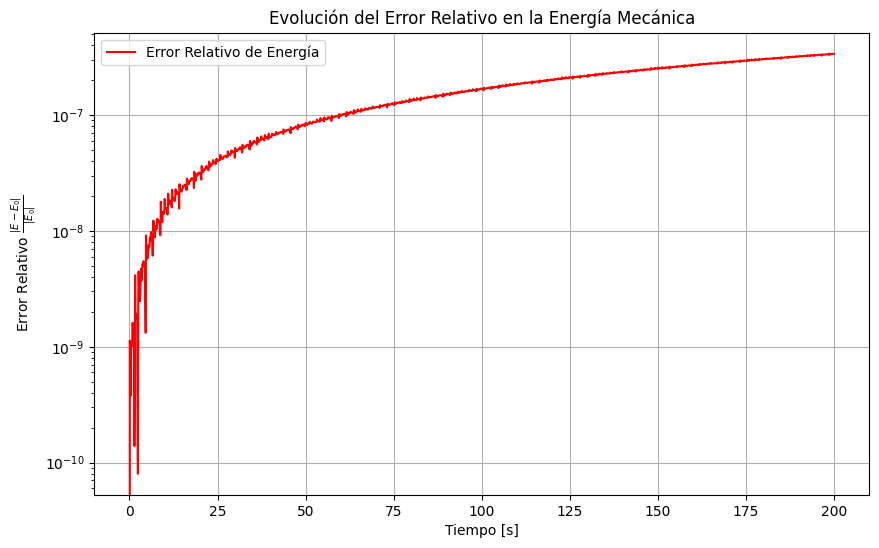

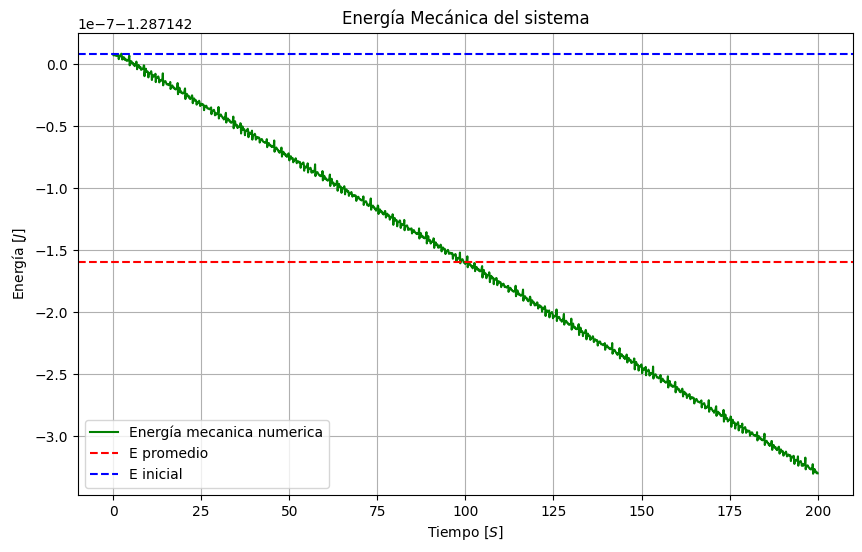

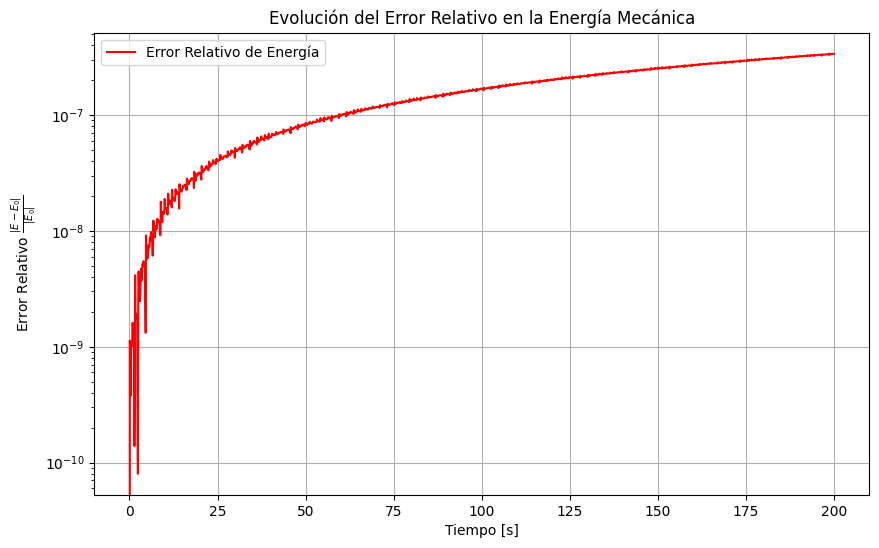

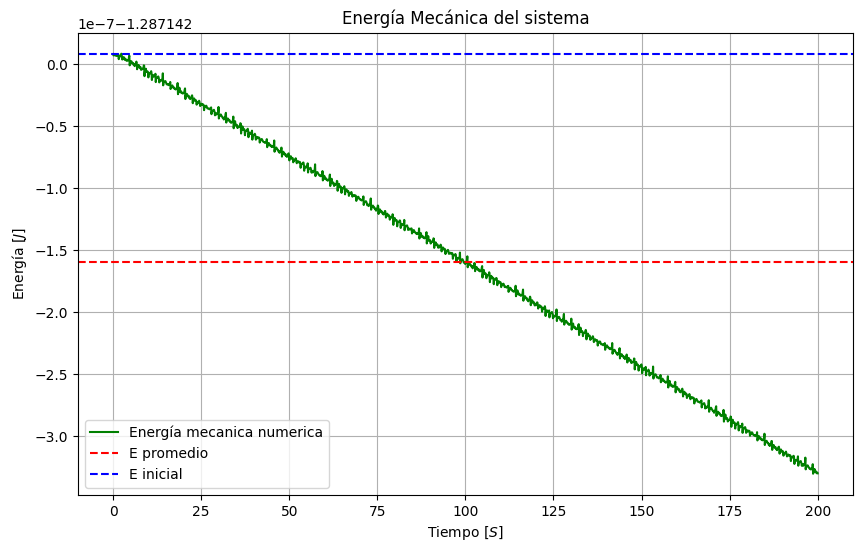

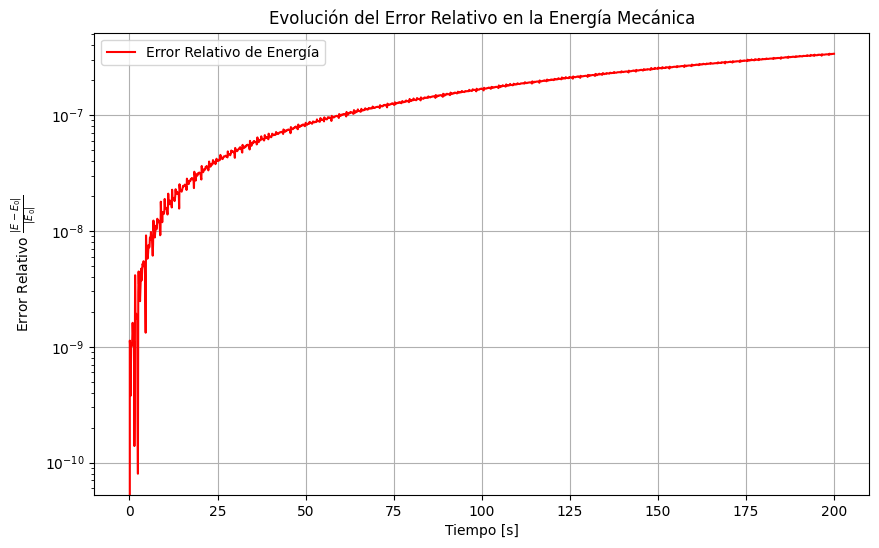

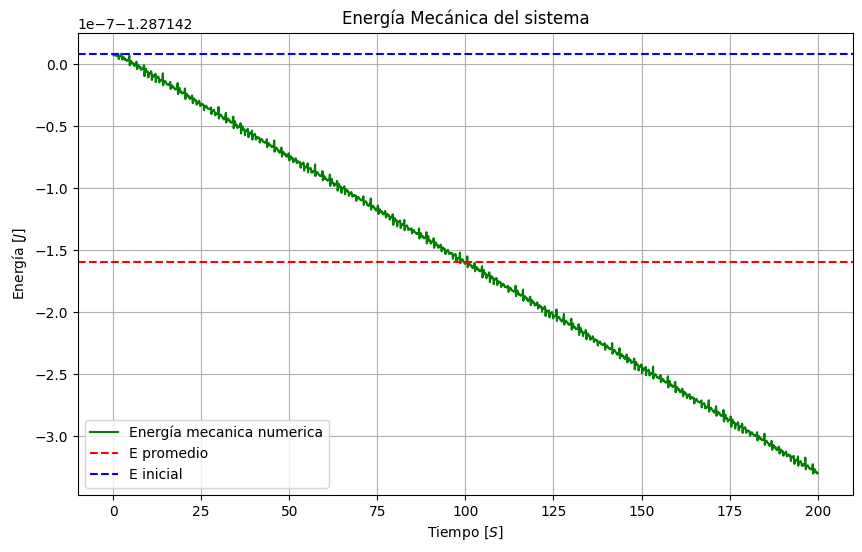

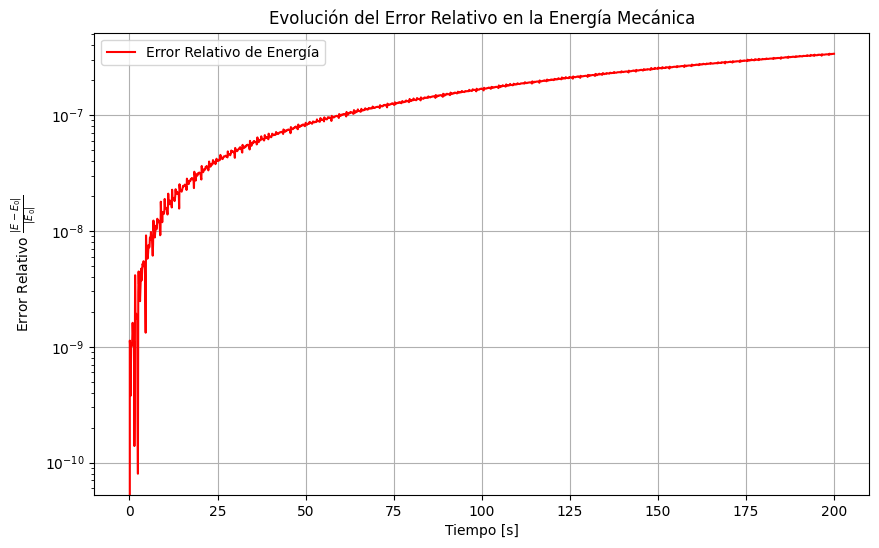

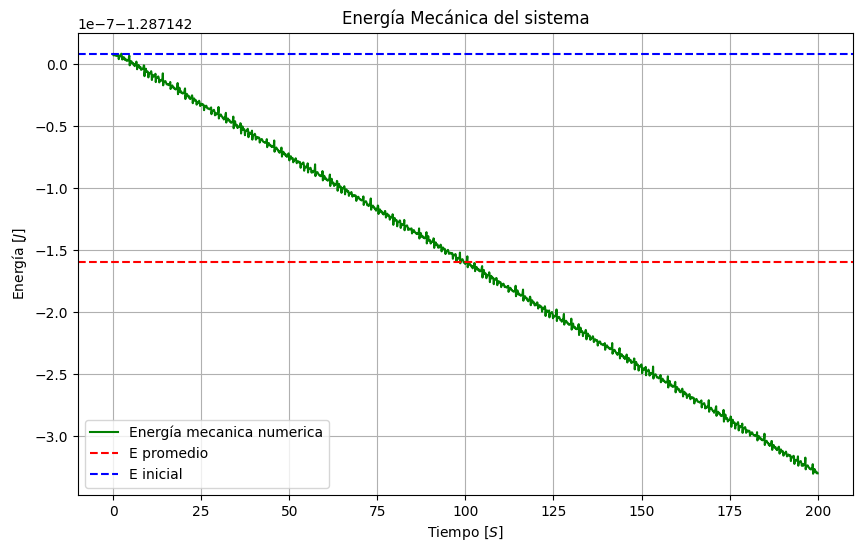

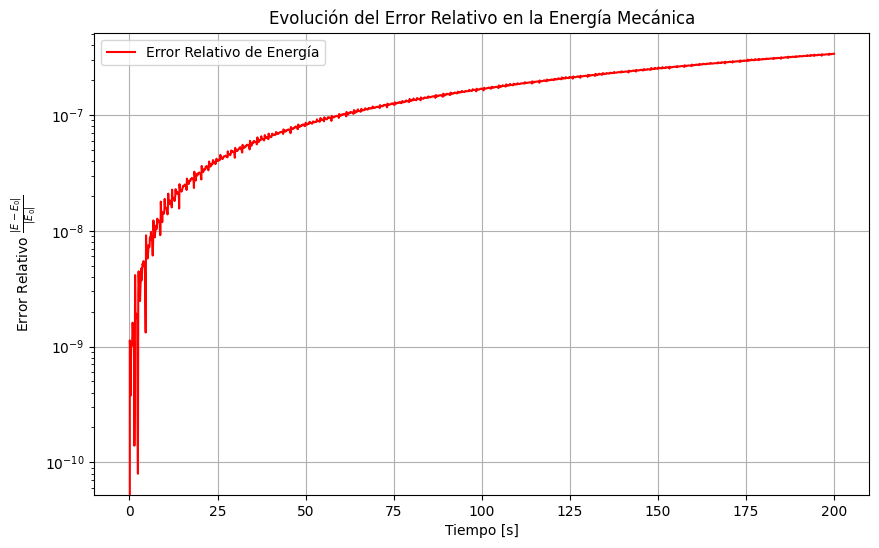

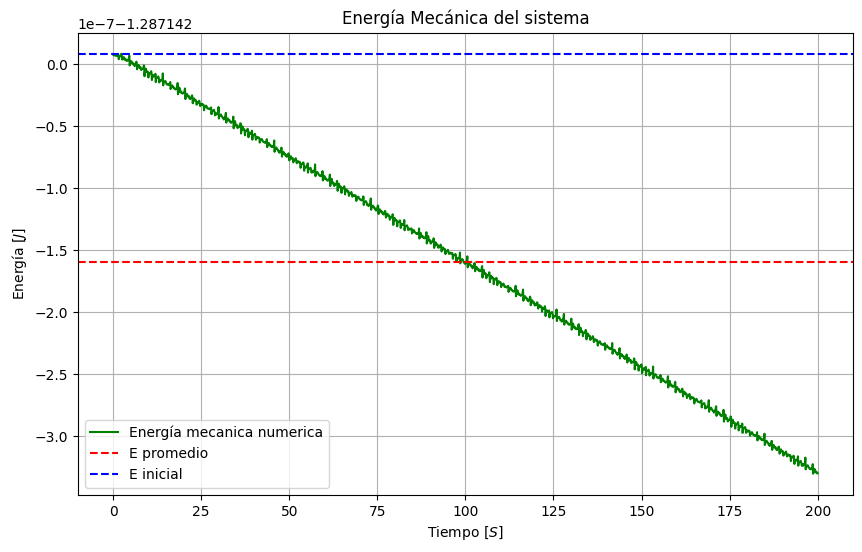

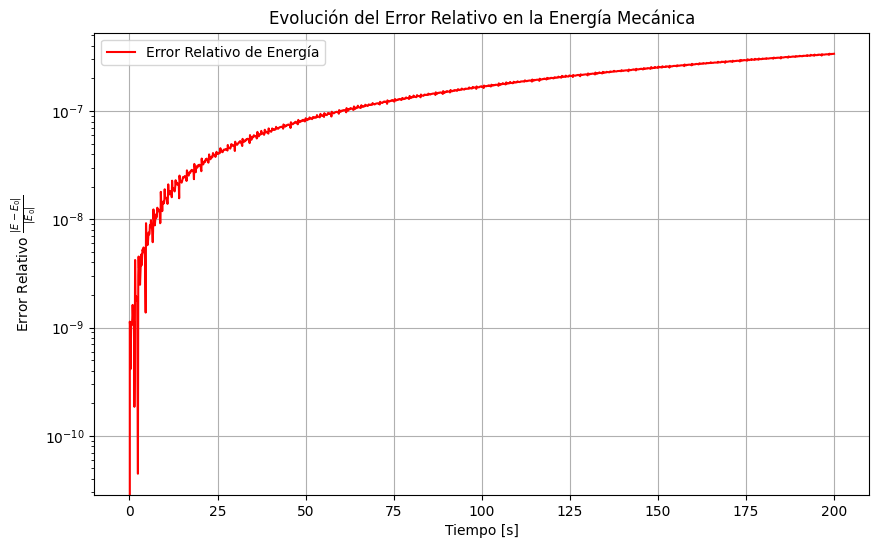

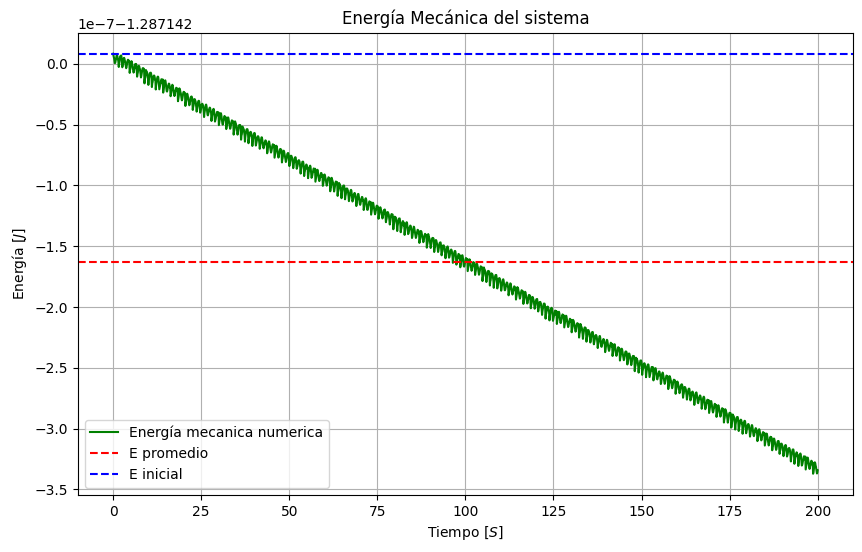

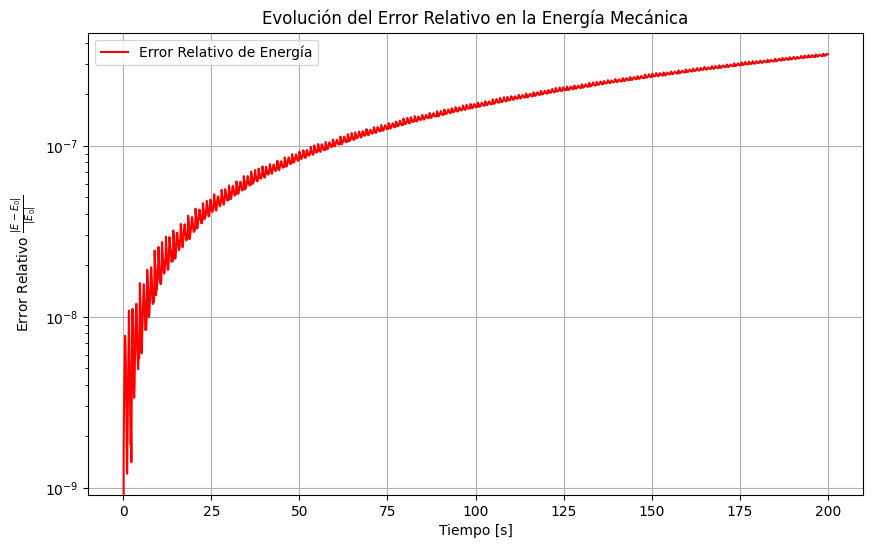

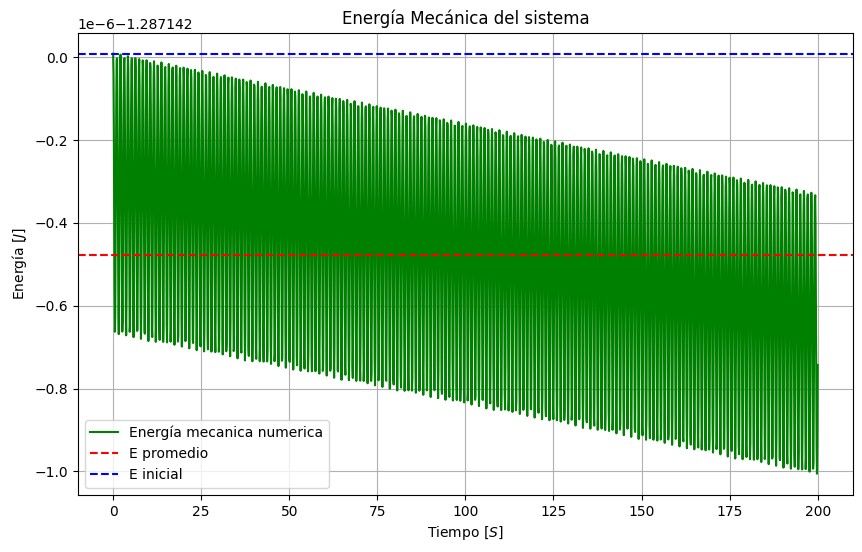

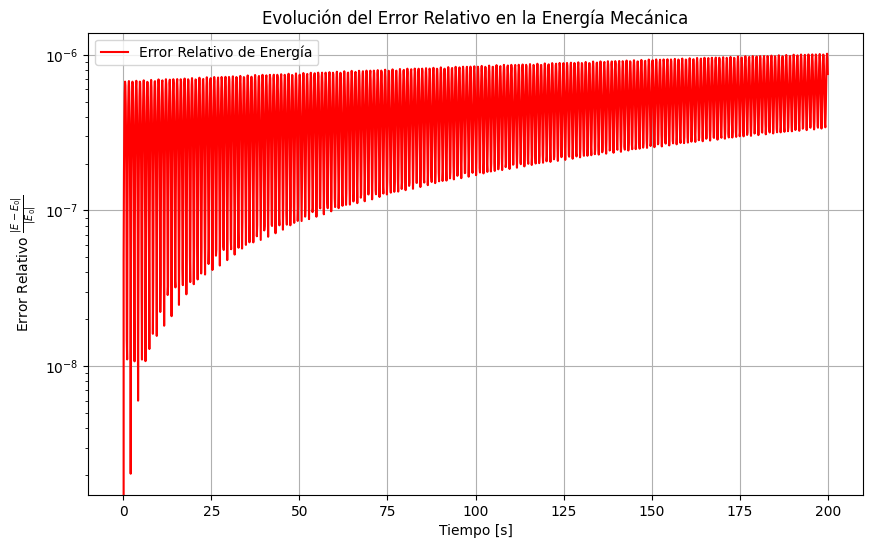

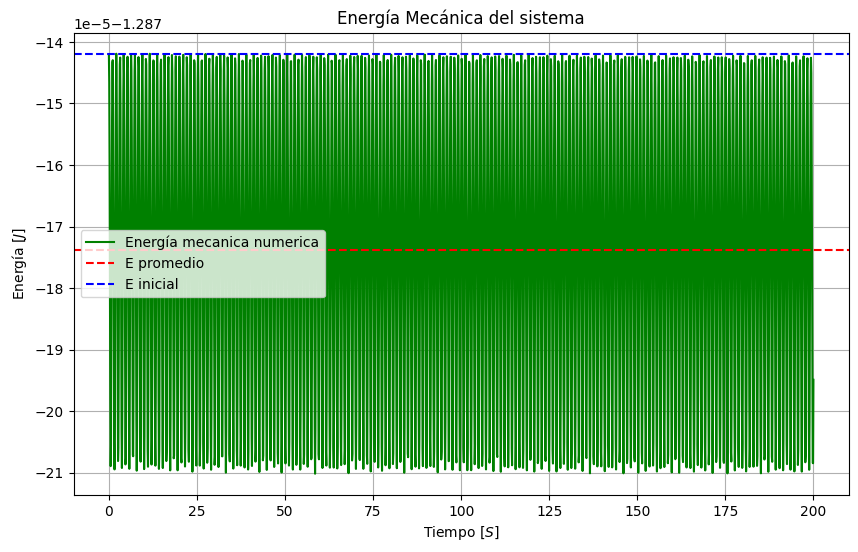

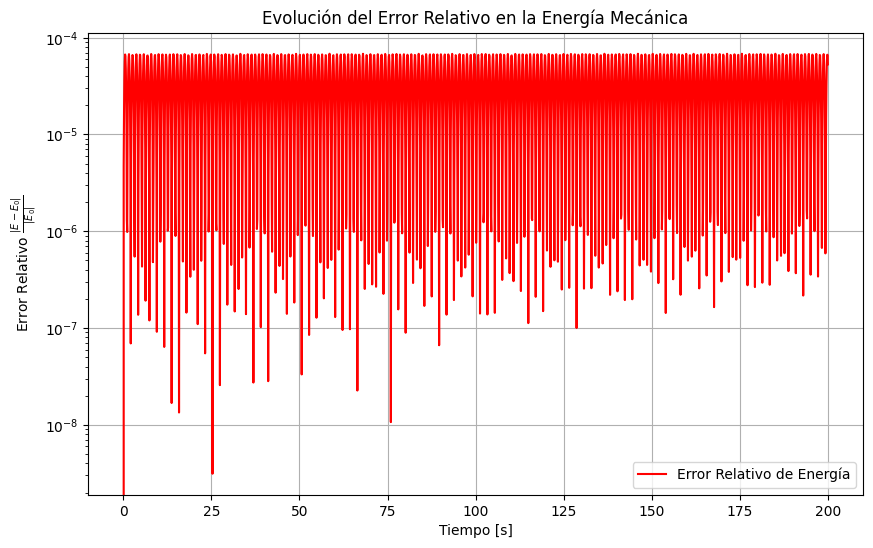

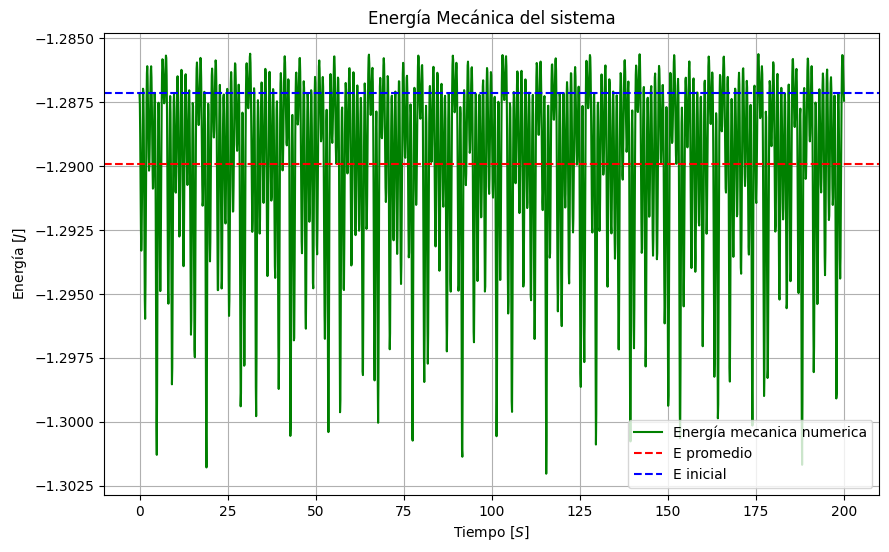

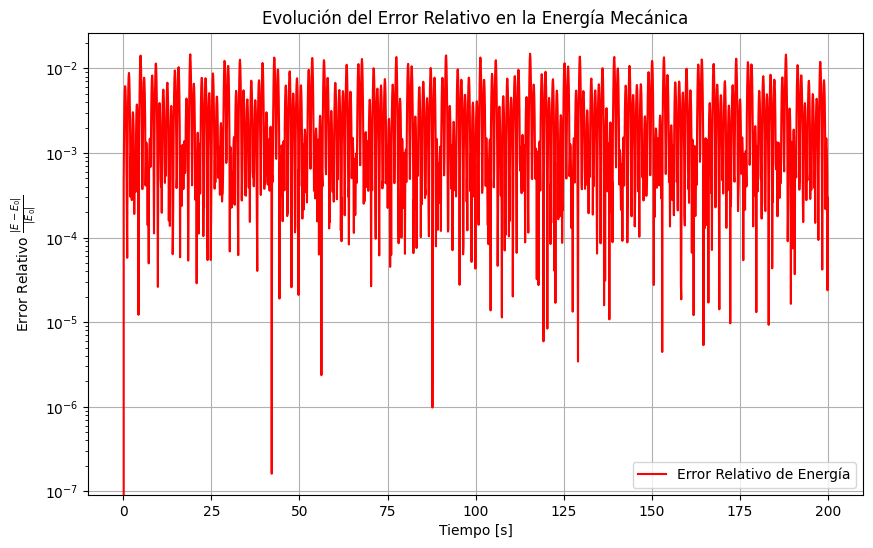

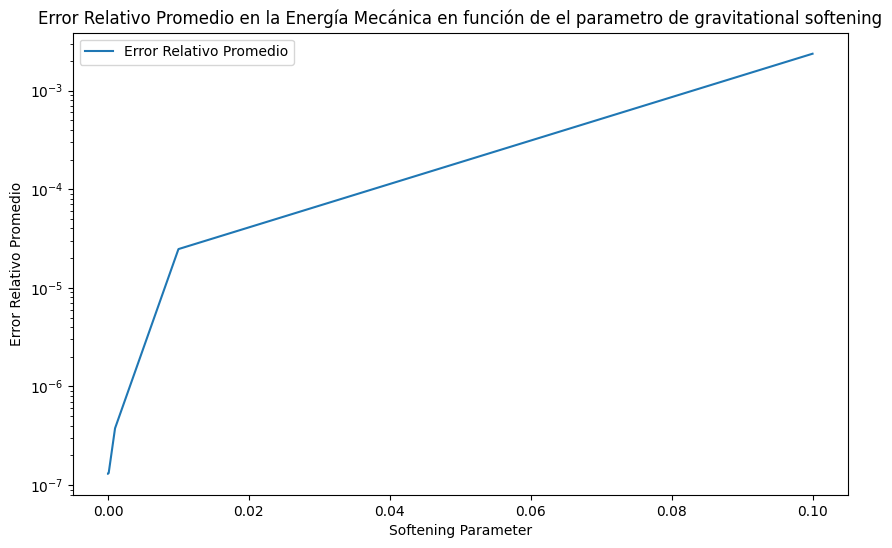

In [74]:
epsilons = [1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]

mean_mechanical_energy = np.zeros_like(epsilons)

print(epsilons)
for index,eps in enumerate(epsilons):
    sol = solve_three_body_problem_solve_ivp(m1, m2, m3, state0, t, eps)
    total_energy, potential_energy, kinetic_energy = calculate_mechanical_energy(sol, m1, m2, m3, num_points, t, True)
    relative_error = np.abs(total_energy - total_energy[0]) / np.abs(total_energy[0])
    mean_mechanical_energy[index] = np.mean(relative_error)


plt.figure(figsize=(10, 6))
plt.plot(epsilons, mean_mechanical_energy, label="Error Relativo Promedio")
plt.yscale("log")
plt.xlabel("Softening Parameter")
plt.ylabel("Error Relativo Promedio")
plt.title("Error Relativo Promedio en la Energía Mecánica en función de el parametro de gravitational softening")
plt.legend()

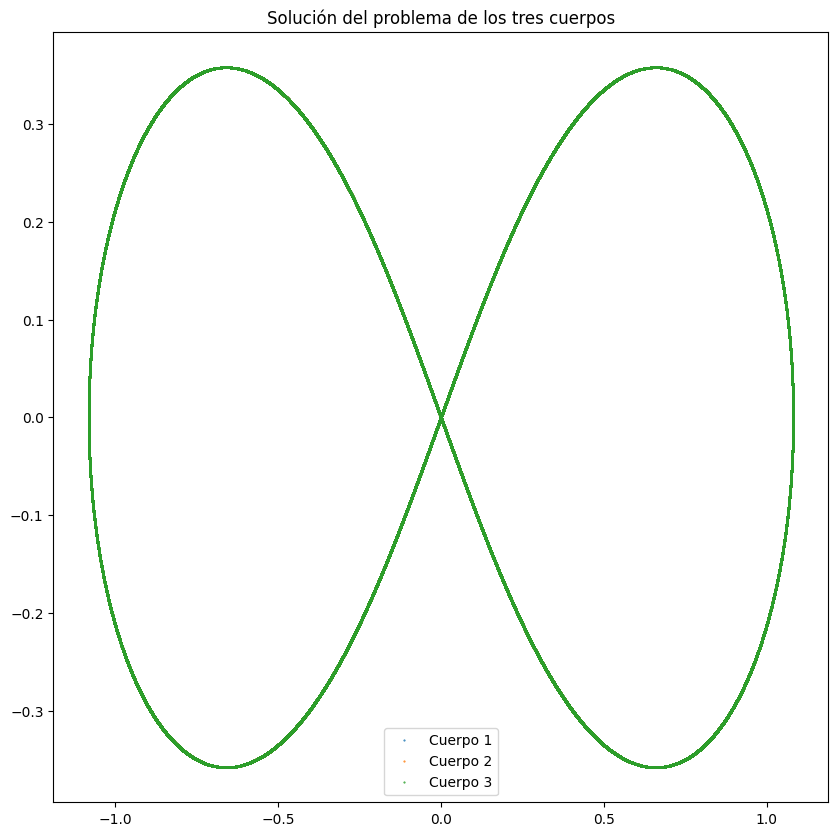

In [75]:
# ----------------------
# System parameters
# ----------------------

G = 1.0  # Gravitational constant normalized
m1 ,m2 , m3 = 1, 1, 1

# ----------------------------
# Initial conditions
# ----------------------------

r1 = np.array([0.97000436, -0.24308753, 0.0])
r2 = np.array([-0.97000436, 0.24308753, 0.0])
r3 = np.array([0.0, 0.0, 0.0])

v1 = np.array([0.4662036850, 0.43236573, 0.0])
v2 = np.array([0.4662036850, 0.43236573, 0.0])
v3 = np.array([-0.93240737, -0.86473146, 0.0])

state0 = np.concatenate((r1, v1, r2, v2, r3, v3))
dt=0.0005
steps=400000


sol = solve_three_body_problem_leap_frog(m1, m2, m3, state0, dt, steps, 0)
save_three_body_solution(sol, "three_body_solution_moore_setup.csv")
plot_projection_three_body_solution(sol, "Solución del problema de los tres cuerpos")


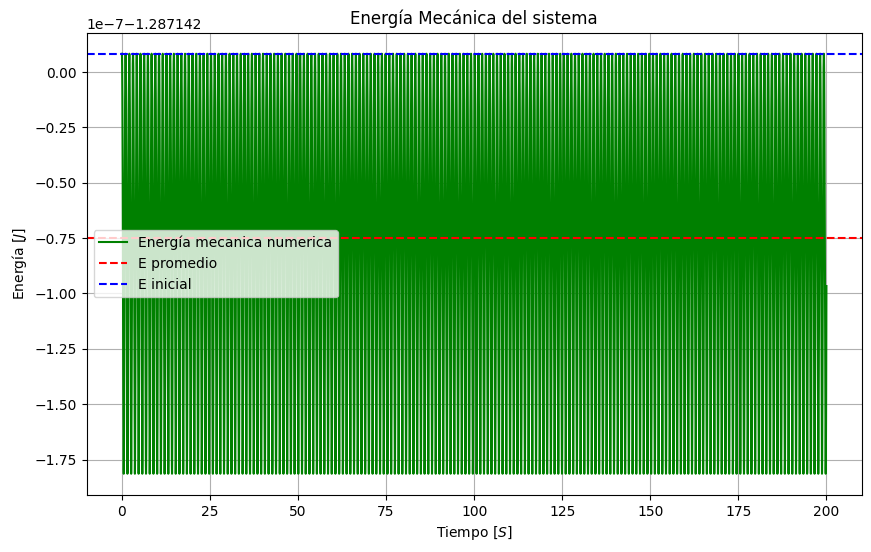

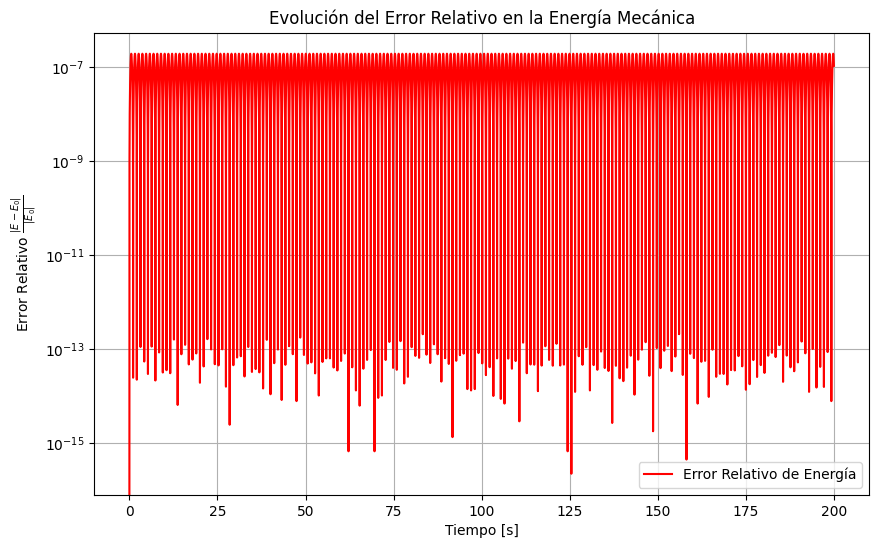

(array([-1.28714199, -1.28714199, -1.28714199, ..., -1.2871421 ,
        -1.2871421 , -1.2871421 ]),
 array([-2.49999999, -2.50000029, -2.50000117, ..., -2.59826979,
        -2.59804295, -2.59781597]),
 array([1.212858  , 1.2128583 , 1.21285918, ..., 1.3111277 , 1.31090086,
        1.31067388]))

In [76]:
num_points = len(sol.x1)
t = np.arange(0, num_points) * dt
calculate_mechanical_energy(sol, m1, m2, m3, num_points, t)

In [34]:
# ----------------------
# System parameters
# ----------------------

G = 1.0  # Gravitational constant normalized
m1 = 1
m2 = 1
m3 = 1

def run_simulation_and_plot(
    r1, v1, r2, v2, r3, v3, 
    m1, m2, m3, 
    dt, steps, 
    title_suffix=""
):
    # Estado inicial
    state0 = np.concatenate((r1, v1, r2, v2, r3, v3))

    # Integración
    sol = solve_three_body_problem_leap_frog(m1, m2, m3, state0, dt, steps, 0)

    # Gráficas
    plot_projection_three_body_solution(
        sol,
        f"Proyección órbita {title_suffix}",
    )
    plot_three_body_solution(
        sol,
        f"Órbitas completas {title_suffix}",
    )

    # Energía
    calculate_mechanical_energy(sol, m1, m2, m3, len(sol.x1), np.arange(0, len(sol.x1)) * dt)


# ----------------------------
# Initial conditions
# ----------------------------

r1 = np.array([0.97000436, -0.24308753, 0.0])
r2 = np.array([-0.97000436, 0.24308753, 0.0])
r3 = np.array([0.0, 0.0, 0.0])

v1 = np.array([0.4662036850, 0.43236573, 0])
v2 = np.array([0.4662036850, 0.43236573, 0.1])
v3 = np.array([-0.93240737, -0.86473146, 0])

state0 = np.concatenate((r1, v1, r2, v2, r3, v3))

dt = 0.0005
steps = 240000 

num_points = 240000
t = np.arange(0, num_points) * dt



run_simulation_and_plot(
    r1, v1, r2, v2, r3, v3, 
    m1, m2, m3, 
    dt, steps, 
    "setup de Christopher Moore con velocidades iniciales distintas ($\\Delta V = 0.1$)"
)


# ----------------------------
# Initial conditions
# ----------------------------

r1 = np.array([0.97000436, -0.24308753, 0.0])
r2 = np.array([-0.97000436, 0.24308753, 0.0])
r3 = np.array([0.0, 0.0, 0.0])

v1 = np.array([0.4662036850, 0.43236573, 0])
v2 = np.array([0.4662036850, 0.43236573, 0.5])
v3 = np.array([-0.93240737, -0.86473146, 0])

state0 = np.concatenate((r1, v1, r2, v2, r3, v3))

dt = 0.0005
steps = 240000 

num_points = 240000
t = np.arange(0, num_points) * dt



run_simulation_and_plot(
    r1, v1, r2, v2, r3, v3, 
    m1, m2, m3, 
    dt, steps, 
    "setup de Christopher Moore con velocidades iniciales distintas ($\\Delta V = 0.5$)"
)



KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from scipy.interpolate import interp1d

G = 1.0
m1, m2, m3 = 1.0, 1.0, 1.0

# ---------- Condiciones iniciales "figura 8" en r2, r3 y v2, v3 ----------
r1 = np.array([ 0.97000436, -0.24308753,  0.0])
r2 = np.array([-0.97000436,  0.24308753,  0.0])
r3 = np.array([ 0.0       ,  0.0       ,  0.0])

v2 = np.array([ 0.4662036850,  0.43236573,  0.0])
v3 = np.array([-0.93240737 , -0.86473146,  0.0])

# ---------- Rango de velocidades para v1 ----------
# Por ejemplo, variamos v1_x entre [0.3, 0.6] y v1_y entre [0.3, 0.6], y z=0
N = 50
v1x_vals = np.linspace(0.4462, 0.4862, N)  # 0.02 abajo/arriba
v1y_vals = np.linspace(0.4124, 0.4524, N)  # 0.02 abajo/arriba

# Generamos la lista de velocidades a probar
velocities = []
for vx1 in v1x_vals:
    for vy1 in v1y_vals:
        velocities.append([vx1, vy1, 0.0])
velocities = np.array(velocities)

#  Parametros de integracion ----------
dt = 0.0005
steps = 500000  # Para un recorrido largo

def compute_single_poincare(velocity):
    """
    Computa la sección de Poincaré (y=0, vy>0) para una condición inicial dada en v1.
    Retorna lista de (x_poin, vx_poin).
    """
    v1 = np.array(velocity)
    state0 = np.concatenate((r1, v1, r2, v2, r3, v3))
    
    # Resolver el problema de tres cuerpos con LeapFrog
    solution = solve_three_body_problem_leap_frog(m1, m2, m3, state0, dt, steps, 1e-2)

    x1 = solution.x1
    y1 = solution.y1
    vx1 = solution.vx1
    vy1 = solution.vy10

    # Buscar cruces y=0 con vy>0 (Interpolación lineal)
    poincare_points = []
    for i in range(len(y1) - 1):
        if (y1[i] < 0) and (y1[i+1] > 0) and (vy1[i] > 0) and (vy1[i+1] > 0):
            frac = -y1[i] / (y1[i+1] - y1[i])  # fraccion para y=0
            x_poincare  = x1[i]  + frac * (x1[i+1]  - x1[i])
            vx_poincare = vx1[i] + frac * (vx1[i+1] - vx1[i])
            poincare_points.append((x_poincare, vx_poincare))
    return poincare_points


def compute_poincare_section_parallel():
    """
    Ejecuta la simulación en paralelo para todas las velocidades en 'velocities'.
    """
    num_workers = cpu_count()
    print(f"Usando {num_workers} núcleos para la simulación...")

    with Pool(num_workers) as pool:
        # tqdm(pool.imap(...)) para barra de progreso
        results = list(tqdm(pool.imap(compute_single_poincare, velocities), total=len(velocities)))

    # results es lista de listas => aplanamos
    x_poincare, vx_poincare = [], []
    for points in results:
        for x, vx in points:
            x_poincare.append(x)
            vx_poincare.append(vx)
    return np.array(x_poincare), np.array(vx_poincare)

def plot_poincare_section(x_poincare, vx_poincare):
    """
    Diagrama de Poincaré (x vs vx) con y=0, vy>0.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(x_poincare, vx_poincare, s=2, alpha=0.6)
    plt.xlabel(r"$x$")
    plt.ylabel(r"$v_x$")
    plt.title("Diagrama de Poincaré - Problema de Tres Cuerpos (Barrido de v1)")
    plt.grid(True)
    plt.show()

def save_poincare_to_csv(x_poincare, vx_poincare, filename="poincare_data.csv"):
    df = pd.DataFrame({"x": x_poincare, "vx": vx_poincare})
    df.to_csv(filename, index=False)
    print(f"Datos guardados en {filename}")

# ---------- Ejecutamos ----------
x_poincare, vx_poincare = compute_poincare_section_parallel()
save_poincare_to_csv(x_poincare, vx_poincare, "poincare_data.csv")
plot_poincare_section(x_poincare, vx_poincare)

Usando 20 núcleos para la simulación...


  0%|          | 0/2500 [00:12<?, ?it/s]


KeyboardInterrupt: 

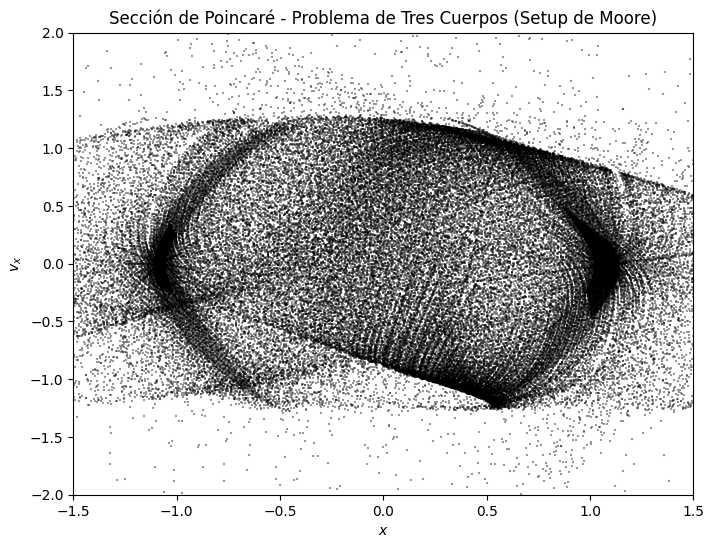

In [ ]:
def plot_poincare_from_csv(filename="poincare_data.csv", x_range=(-2, 2), vx_range=(-2, 2)):
    """
    Carga datos de un CSV y grafica la sección de Poincaré.
    """
    df = pd.read_csv(filename)

    df_filtered = df[(df["x"] >= x_range[0]) & (df["x"] <= x_range[1]) &
                     (df["vx"] >= vx_range[0]) & (df["vx"] <= vx_range[1])]
    
    plt.figure(figsize=(8, 6))
    plt.scatter(df_filtered["x"], df_filtered["vx"] , marker='+', s=1, alpha=0.4, c='black') 
    plt.xlabel(r"$x$")
    plt.ylabel(r"$v_x$")
    plt.xlim(-1.5, 1.5) 
    plt.ylim(-2, 2)      
    plt.title("Sección de Poincaré - Problema de Tres Cuerpos (Setup de Moore)")
    plt.show()

# Cargar y graficar datos desde CSV
plot_poincare_from_csv()


In [35]:
def restricted_three_body_leap_frog(state, mu, dt, softening=0):
    x, y, z, vx, vy, vz = state
    r = np.array([x, y, z])
    v = np.array([vx, vy, vz])

    # Posiciones de los primarios en sistema rotante
    r1 = np.array([-mu, 0, 0])
    r2 = np.array([1 - mu, 0, 0])

    # Vectores hacia los primarios
    r13 = r - r1
    r23 = r - r2

    d13 = np.sqrt(np.linalg.norm(r13)**2 + softening**2)
    d23 = np.sqrt(np.linalg.norm(r23)**2 + softening**2)

    # Aceleración en el sistema rotante (incluye coriolis y centrífuga)
    a = (
        - (1 - mu) * r13 / d13**3
        - mu * r23 / d23**3
        + np.array([2 * vy + x, -2 * vx + y, 0])
    )

    v_half = v + 0.5 * a * dt
    r_new = r + v_half * dt

    # Recalcular aceleración con nueva posición
    r13_new = r_new - r1
    r23_new = r_new - r2

    d13_new = np.sqrt(np.linalg.norm(r13_new)**2 + softening**2)
    d23_new = np.sqrt(np.linalg.norm(r23_new)**2 + softening**2)

    a_new = (
        - (1 - mu) * r13_new / d13_new**3
        - mu * r23_new / d23_new**3
        + np.array([2 * v_half[1] + r_new[0], -2 * v_half[0] + r_new[1], 0])
    )

    v_new = v_half + 0.5 * a_new * dt

    return np.concatenate((r_new, v_new))

def solve_rtbp(mu, state0, dt, steps, softening=1e-5):
    trajectory = np.zeros((steps, len(state0)))
    trajectory[0] = state0

    for i in range(1, steps):
        trajectory[i] = restricted_three_body_leap_frog(trajectory[i - 1], mu, dt, softening)

    return trajectory


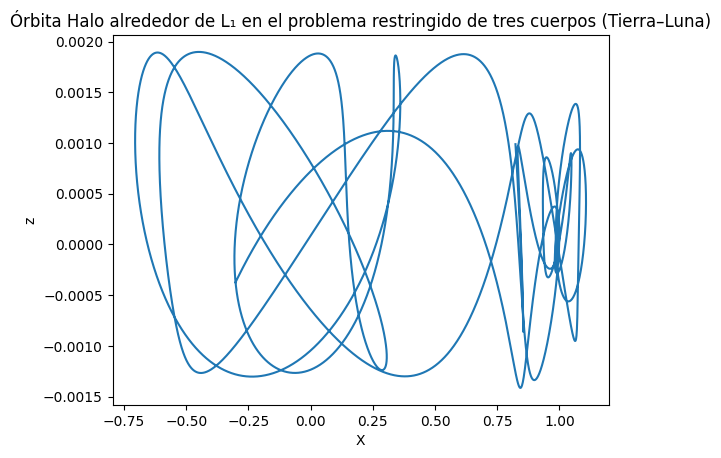

In [41]:
import plotly.graph_objects as go

mu = 0.0121505856


state0 = np.array(
    [
        0.82339082,  # x
        0.0,  # y (≈ 0)
        0.00098941,  # z
        0.0,  # vx
        0.12634273,  # vy
        0.0,  # vz
    ]
)
dt = 0.001
period = 12.1587  # días (según tu dato)
dt = 0.001
steps = int(period / dt) * 2  # al menos 2 ciclos


traj = solve_rtbp(mu, state0, dt, steps)

x, y, z = traj[:, 0], traj[:, 1], traj[:, 2]


plt.plot(x, z)
plt.xlabel("X")
plt.ylabel("z")
plt.title(
    "Órbita Halo alrededor de L₁ en el problema restringido de tres cuerpos (Tierra–Luna)"
)


fig = go.Figure(
    data=[
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode="lines",
            line=dict(color="blue", width=2),
            name="Órbita",
        )
    ]
)
# Primario 1 (por ejemplo, Tierra)
fig.add_trace(
    go.Scatter3d(
        x=[-mu],
        y=[0],
        z=[0],
        mode="markers+text",
        marker=dict(size=5, color="blue"),
        text=["Tierra"],
        textposition="top center",
        name="Tierra",
    )
)

# Primario 2 (por ejemplo, Luna)
fig.add_trace(
    go.Scatter3d(
        x=[1 - mu],
        y=[0],
        z=[0],
        mode="markers+text",
        marker=dict(size=5, color="gray"),
        text=["Luna"],
        textposition="top center",
        name="Luna",
    )
)

fig.update_layout(
    title=r'Órbita Halo alrededor de L₁ en el sistema Tierra–Luna',
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z",
        aspectmode="cube",
    ),
    width=800,  # ancho en píxeles
    height=600,  # alto en píxeles
    margin=dict(l=0, r=0, b=0, t=40),
)

fig.show()

100%|██████████| 2500/2500 [09:06<00:00,  4.58it/s]


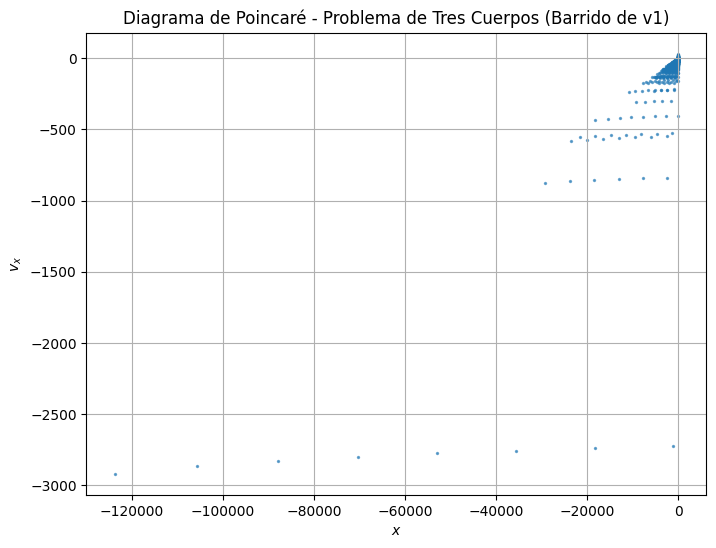

Datos guardados en poincare_rtbp.csv


In [ ]:
def compute_single_poincare_rtbp(velocity):
    vx, vy = velocity
    state0 = np.array([0.8, 0.0, 0.0, vx, vy, 0.0])  # posición inicial y velocidad variable

    traj = solve_rtbp(mu, state0, dt, steps)

    x = traj[:, 0]
    y = traj[:, 1]
    vx = traj[:, 3]
    vy = traj[:, 4]

    poincare_points = []
    for i in range(len(y) - 1):
        if (y[i] < 0) and (y[i+1] > 0) and (vy[i] > 0) and (vy[i+1] > 0):
            frac = -y[i] / (y[i+1] - y[i])
            x_poin = x[i] + frac * (x[i+1] - x[i])
            vx_poin = vx[i] + frac * (vx[i+1] - vx[i])
            poincare_points.append((x_poin, vx_poin))
    return poincare_points


N = 50
vx_vals = np.linspace(-0.2, 0.2, N)
vy_vals = np.linspace(0.1, 0.4, N)

velocities = [(vx, vy) for vx in vx_vals for vy in vy_vals]


def compute_poincare_section_rtbp_parallel():
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(compute_single_poincare_rtbp, velocities), total=len(velocities)))
    
    x_poincare, vx_poincare = [], []
    for points in results:
        for x, vx in points:
            x_poincare.append(x)
            vx_poincare.append(vx)
    return np.array(x_poincare), np.array(vx_poincare)

mu = 0.0121505856  # Tierra-Luna

dt = 0.001
steps = 50000

x_poincare, vx_poincare = compute_poincare_section_rtbp_parallel()
plot_poincare_section(x_poincare, vx_poincare)
save_poincare_to_csv(x_poincare, vx_poincare, "poincare_rtbp.csv")


In [2]:
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from numba import njit
from multiprocessing import cpu_count

# Parámetros globales
mu = 0.0121505856
dt = 0.001
steps = 50000

# ===========================
# 1. Simulador RTBP (Leap-Frog)
# ===========================
def restricted_three_body_leap_frog(state, mu, dt, softening=0):
    x, y, z, vx, vy, vz = state
    r = np.array([x, y, z])
    v = np.array([vx, vy, vz])
    r1 = np.array([-mu, 0, 0])
    r2 = np.array([1 - mu, 0, 0])

    r13 = r - r1
    r23 = r - r2
    d13 = np.sqrt(np.dot(r13, r13) + softening**2)
    d23 = np.sqrt(np.dot(r23, r23) + softening**2)

    a = (
        - (1 - mu) * r13 / d13**3
        - mu * r23 / d23**3
        + np.array([2 * vy + x, -2 * vx + y, 0])
    )

    v_half = v + 0.5 * a * dt
    r_new = r + v_half * dt

    r13_new = r_new - r1
    r23_new = r_new - r2
    d13_new = np.sqrt(np.dot(r13_new, r13_new) + softening**2)
    d23_new = np.sqrt(np.dot(r23_new, r23_new) + softening**2)

    a_new = (
        - (1 - mu) * r13_new / d13_new**3
        - mu * r23_new / d23_new**3
        + np.array([2 * v_half[1] + r_new[0], -2 * v_half[0] + r_new[1], 0])
    )

    v_new = v_half + 0.5 * a_new * dt

    return np.concatenate((r_new, v_new))

def solve_rtbp(mu, state0, dt, steps, softening=1e-5):
    traj = np.zeros((steps, len(state0)))
    traj[0] = state0
    for i in range(1, steps):
        traj[i] = restricted_three_body_leap_frog(traj[i-1], mu, dt, softening)
    return traj

# ===========================
# 2. Cálculo eficiente de cruces (con numba)
# ===========================
@njit
def extract_poincare_points(x, y, vx, vy):
    points = []
    for i in range(len(y) - 1):
        if y[i] < 0 and y[i+1] > 0 and vy[i] > 0 and vy[i+1] > 0:
            frac = -y[i] / (y[i+1] - y[i])
            x_p = x[i] + frac * (x[i+1] - x[i])
            vx_p = vx[i] + frac * (vx[i+1] - vx[i])
            points.append((x_p, vx_p))
    return points

# ===========================
# 3. Función paralelizable
# ===========================
def compute_single_poincare_rtbp(velocity):
    vx0, vy0 = velocity
    state0 = np.array([0.8, 0.0, 0.0, vx0, vy0, 0.0])
    traj = solve_rtbp(mu, state0, dt, steps)

    y = traj[:, 1]
    if np.all(y > 0) or np.all(y < 0):
        return []

    x = traj[:, 0]
    vx = traj[:, 3]
    vy = traj[:, 4]

    return extract_poincare_points(x, y, vx, vy)

# ===========================
# 4. Paralelización y ejecución
# ===========================
def compute_poincare_section_rtbp_parallel():
    N = 10
    print(f"Simulando {N*N} condiciones iniciales...")
    vx_vals = np.linspace(-0.2, 0.2, N)
    vy_vals = np.linspace(0.1, 0.4, N)
    velocities = [(vx, vy) for vx in vx_vals for vy in vy_vals]

    print(f"Simulando {len(velocities)} condiciones iniciales...")
    results = Parallel(n_jobs=cpu_count())(
        delayed(compute_single_poincare_rtbp)(v) for v in tqdm(velocities)
    )

    x_poincare, vx_poincare = [], []
    for points in results:
        for x, vx in points:
            x_poincare.append(x)
            vx_poincare.append(vx)
    return np.array(x_poincare), np.array(vx_poincare)

# ===========================
# 5. Visualización y guardado
# ===========================
# def plot_poincare_section(x_p, vx_p):
#     plt.figure(figsize=(8, 6))
#     plt.scatter(x_p, vx_p, s=1, alpha=0.5, color='black')
#     plt.xlabel(r"$x$")
#     plt.ylabel(r"$v_x$")
#     plt.title("Sección de Poincaré - Problema de Tres Cuerpos Restringido")
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

def save_poincare_to_csv(x_p, vx_p, filename="poincare_rtbp.csv"):
    df = pd.DataFrame({"x": x_p, "vx": vx_p})
    df.to_csv(filename, index=False)
    print(f"Guardado en {filename}")

# ===========================
# Ejecutar todo
# ===========================
x_poincare, vx_poincare = compute_poincare_section_rtbp_parallel()
# plot_poincare_section(x_poincare, vx_poincare)
save_poincare_to_csv(x_poincare, vx_poincare)


Simulando 100 condiciones iniciales...
Simulando 100 condiciones iniciales...


100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


Guardado en poincare_rtbp.csv


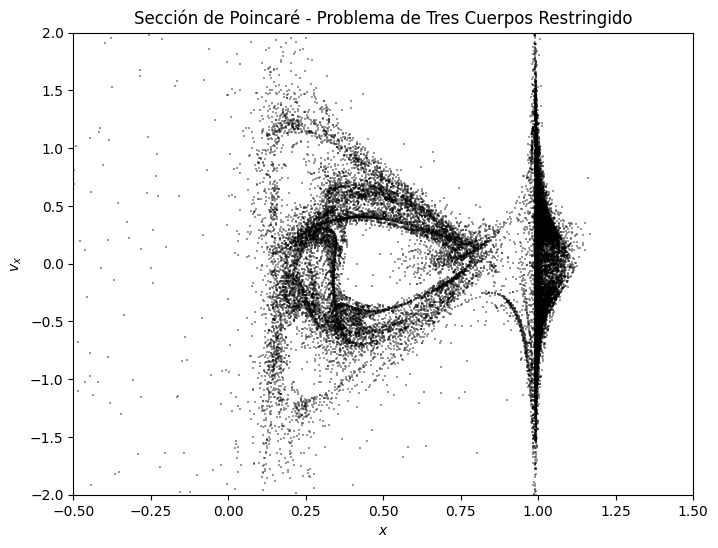

In [17]:
def plot_poincare_from_csv(filename="poincare_rtbp.csv", x_range=(-2, 2), vx_range=(-2, 2)):
    """
    Carga datos de un CSV y grafica la sección de Poincaré.
    """
    df = pd.read_csv(filename)

    # df_filtered = df[(df["x"] >= x_range[0]) & (df["x"] <= x_range[1]) &
    #                  (df["vx"] >= vx_range[0]) & (df["vx"] <= vx_range[1])]
    df_filtered = df
    
    plt.figure(figsize=(8, 6))
    plt.scatter(df_filtered["x"], df_filtered["vx"] , marker='+', s=1, alpha=0.4, c='black') 
    plt.xlabel(r"$x$")
    plt.ylabel(r"$v_x$")
    plt.xlim(-0.5, 1.5) 
    plt.ylim(-2, 2)      

    plt.title("Sección de Poincaré - Problema de Tres Cuerpos Restringido")
    plt.show()

# Cargar y graficar datos desde CSV
plot_poincare_from_csv()


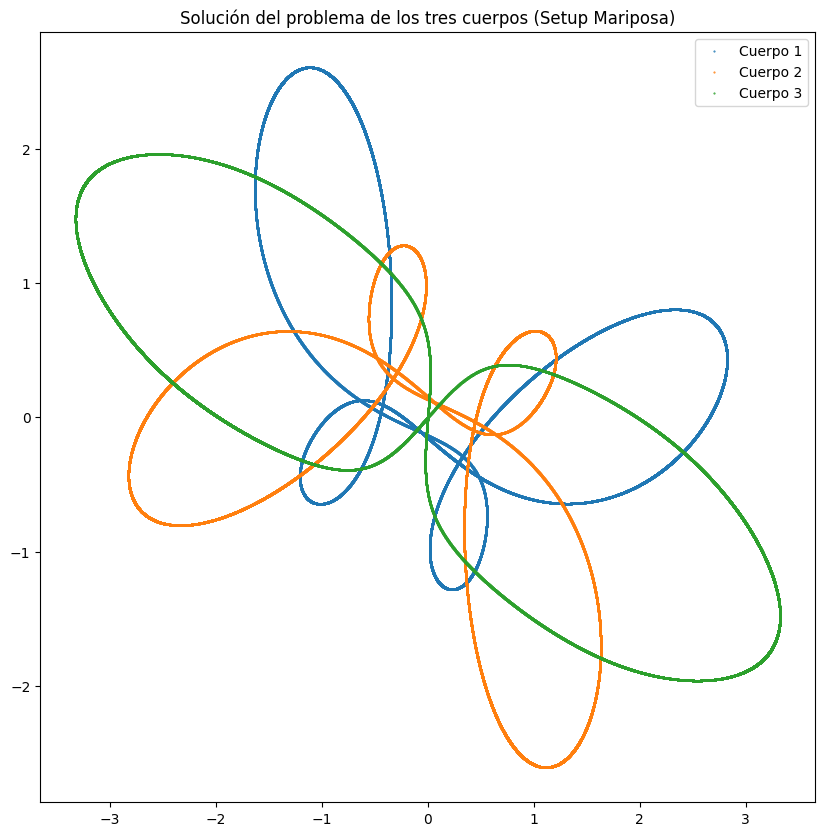

In [60]:
# ----------------------
# System parameters
# ----------------------

G = 1.0  # Gravitational constant normalized
m1 ,m2 , m3 = 1, 1, 1

# ----------------------------
# Initial conditions
# ----------------------------

r1 = [-0.9826997937, -0.0315203302, 0.0]
r2 = [ 0.9826997937,  0.0315203302, 0.0]
r3 = [0.0, 0.0, 0.0]

v1 = [0.6030557226, 0.5466747521, 0.0]
v2 = [0.6030557226, 0.5466747521, 0.0]
v3 = [-1.2061114452, -1.0933495042, 0.0]



state0 = np.concatenate((r1, v1, r2, v2, r3, v3))
dt=0.0005
steps=80000


sol = solve_three_body_problem_leap_frog(m1, m2, m3, state0, dt, steps, 0)
# save_three_body_solution(sol, "three_body_solution_1_chaos.csv")
plot_projection_three_body_solution(sol, "Solución del problema de los tres cuerpos (Setup Mariposa)")
